# Extra Credit Opportuinity

# Can You Predit a 20 Day Change in Stock Price?
* Get 5 points added to your lowest Major Lab grade (Lab 1, 2, or 3) for completing the extra credit. 
* Get 10 additional points, if you achieve a lower Mean Absolute Error < 25% OR a Correct direction > 57.6%

# Instructions 
1. Create and execute three original 30 day simulation models (Examples below) trying to improve your MAE each time. 
2. Pickel your predictions for each run using the .gz file extension and the file names shown below. 
3. Execute the code in the observations section using the predictions from your best run. 
4. Update with your own observations. Feel free to add any visuals or tables you need to support your observations.
5. State how many Extra Credit points you think you should be awarded.  If you qualify for the 10 additional points, explain how / why you think your model achieves a better result. 

# Rules
* All extra credit work and submissions must be individual.  Do not share your approaches.    
* "Original" simualtions include you making changes to the models, parameter tuning, feature selection, feature engineering, training record selection strategies etc. to achieve a better result. 
* Feel free to run more than three simulations, but only include your best 3 simulations in the final submission. 
* You MUST use the make_cv_folds() function and the train / test folds it creates for the simulation.  DO NOT modify this code in any way.
* You MUST use the example code below to execute your simulations.  
* Only modify the simuilation code to improve the model predictions.   
* You must make a prediction for each of the 30 days and 2,065 test records as shown below.
* You must train your model using some or all of the training data for each respective fold (see examples below).
* DO NOT mix folds in any way. Use the simulation examples as a starting point. Training records for each fold are 20 days older than the test records you are trying to predict. 
* DO NOT add new or future training data to the folds!!! 
* Simulation predictions must be pickled/saved using the filenames: pred_data_e1.gz, pred_data_e2.gz, and pred_data_e3.gz as shown below.
* Your work MUST be reproduceable! I will not award any points if I cannot reproduce your work using the cv_folds below!   
* You may use any scikit learn tools to create better predictions.
* I WILL MAKE A FINAL DETERMINATION ON AWARDING EXTRA CREDIT POINTS. PLEASE ASK IF YOU HAVE QUESTIONS, DO NOT ASSUME.

# Things to Consider Trying
* Modify TfidfVectorizer() parameters to make better features. 
* Use different models or model ensembles.
* Use sklearn.feature_selection (SelectFromModel, SelectKBest) to select better features.
* Try out the AdaBoostRegressor()
* Try dimensionality reduction or remove very rare features from the TfidfVectorizer's sparse matrix.  

In [1]:
import pandas as pd
import cv2
import numpy as np
from sklearn.utils import shuffle
import os
from collections import deque
import copy
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import np_utils
#from config import Config
%matplotlib inline  

In [2]:
%tensorflow_version 2.4.x

UsageError: Line magic function `%tensorflow_version` not found.


In [3]:
import re
import nltk
import spacy
import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
tf.__version__, keras.__version__

('2.5.0', '2.5.0')

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
os.chdir(r"C:\Users\John Olanipekun\Documents\Machine Learning\SMU_Machine_Learning")
os.getcwd()

'C:\\Users\\John Olanipekun\\Documents\\Machine Learning\\SMU_Machine_Learning'

In [7]:
sec_data = pd.read_pickle('SecData.gz')

### Introduction to the Data
**This dataframe has the raw text and metadata for 6,215 SEC 10-Q filings.  Field definitions are below:**
* CompanyCIK - Used by the SEC to identify each company.
* CompanyName - Name of company filing the report
* FileType - These should all be '10-Q'.
* FileDate - Date the filing was made.
* EdgarTextUrl & EdgarHtmlUrl - Links to the report on the SEC's website.
* AccessionNumber - A unique identifier assigned automatically to an accepted submission by the SEC.
* SecFileName - The SEC quarterly index file where this filing is located. 
* CompanyTicker - The stock ticker for this company (when available)
* FileDate_ClosingPrice - Closing stock price on the FileDate.
* FileDate_Plus_20 - The FileDate + 20 days.
* FileDate_Plus_20_Price - Closing stock price on the FileDate_Plus_20.
* Pct_Change_20 - The percentage change between the FileDate_ClosingPrice and the FileDate_Plus_20_Price.
* FileName - The name of this filing on my local filing system in case we need to look at it. 
* file_text_length - Number of text characters  extracted from the filing. I have removed all filings with less than 25,000 characters.
* f_text - The actual raw text extracted from the filing. 

In [8]:
sec_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6215 entries, 2021-01-04 to 2021-06-28
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CompanyCIK              6215 non-null   int64         
 1   CompanyName             6215 non-null   object        
 2   FileType                6215 non-null   object        
 3   FileDate                6215 non-null   datetime64[ns]
 4   EdgarTextUrl            6215 non-null   object        
 5   EdgarHtmlUrl            6215 non-null   object        
 6   AccessionNumber         6215 non-null   object        
 7   SecFileName             6215 non-null   object        
 8   CompanyTicker           6215 non-null   object        
 9   FileDate_ClosingPrice   6215 non-null   float64       
 10  FileDate_Plus_20        6215 non-null   datetime64[ns]
 11  FileDate_Plus_20_Price  6215 non-null   float64       
 12  Pct_Change_20           6215 n

## Some Exploratory Data Analyses  

**What do the attributes look like?**  

In [9]:
sec_data.head()

,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,FileName,file_text_length,f_text
FileDate,,,,,,,,,,,,,,,,
2021-01-04,66382,HERMAN MILLER INC,10-Q,2021-01-04,edgar/data/66382/0000066382-21-000003.txt,edgar/data/66382/0000066382-21-000003-index.html,0000066382-21-000003,2021-QTR1,MLHR,33.099998,2021-01-22,36.779999,11.117826,66382_0000066382-21-000003.txt,68246,b'10-Q 1 mlhr-20201128.htm 10-Q mlhr-20201128 ...
2021-01-04,1098009,America Great Health,10-Q,2021-01-04,edgar/data/1098009/0001185185-20-001804.txt,edgar/data/1098009/0001185185-20-001804-index....,0001185185-20-001804,2021-QTR1,AAGH,0.050000,2021-01-22,0.060000,19.999996,1098009_0001185185-20-001804.txt,48172,"b""10-Q 1 amgreat20190331_10q.htm FORM 10-Q amg..."
2021-01-04,1821318,OTR Acquisition Corp.,10-Q,2021-01-04,edgar/data/1821318/0001104659-21-000366.txt,edgar/data/1821318/0001104659-21-000366-index....,0001104659-21-000366,2021-QTR1,OTRA,10.280000,2021-01-22,10.265000,-0.145908,1821318_0001104659-21-000366.txt,88075,"b""10-Q 1 tm2039245d1_10q.htm FORM 10-Q UNITED ..."
2021-01-05,320187,"NIKE, Inc.",10-Q,2021-01-05,edgar/data/320187/0000320187-21-000003.txt,edgar/data/320187/0000320187-21-000003-index.html,0000320187-21-000003,2021-QTR1,NKE,141.229996,2021-01-25,137.550003,-2.605674,320187_0000320187-21-000003.txt,112930,b'10-Q 1 nke-20201130.htm 10-Q nke-20201130 UN...
2021-01-05,276720,PURE CYCLE CORP,10-Q,2021-01-05,edgar/data/276720/0001140361-21-000183.txt,edgar/data/276720/0001140361-21-000183-index.html,0001140361-21-000183,2021-QTR1,PCYO,11.900000,2021-01-25,11.610000,-2.436975,276720_0001140361-21-000183.txt,100672,b'10-Q 1 brhc10018555_10q.htm 10-Q UNITED STAT...


In [10]:
sec_data.iloc[2:60,12]

FileDate
2021-01-04     -0.145908
2021-01-05     -2.605674
2021-01-05     -2.436975
2021-01-05     -3.969667
2021-01-05      0.831549
2021-01-05      0.000000
2021-01-05      0.480280
2021-01-06     -1.293326
2021-01-06     -0.411403
2021-01-06     43.272724
2021-01-06     -0.407473
2021-01-06     -6.119260
2021-01-06     -0.909093
2021-01-06     -1.918941
2021-01-06      1.861329
2021-01-06     30.451207
2021-01-06     -3.828616
2021-01-07     -0.277775
2021-01-07     13.079987
2021-01-07     10.563387
2021-01-07     -0.990548
2021-01-07     -3.064729
2021-01-07    -15.686269
2021-01-07      4.764648
2021-01-07    -11.530284
2021-01-07      1.865723
2021-01-07     -6.818179
2021-01-07     -7.322177
2021-01-07      8.048822
2021-01-07     12.702479
2021-01-07    -25.758732
2021-01-07     -6.794245
2021-01-07     18.667951
2021-01-07    182.381210
2021-01-07     -5.121380
2021-01-07      6.132541
2021-01-07      5.891065
2021-01-07     -3.021358
2021-01-07     -3.381643
2021-01-07     -

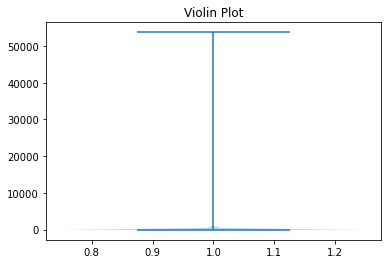

In [11]:
# Extract Figure and Axes instance
fig, ax = plt.subplots()

# Create a plot
ax.violinplot(sec_data['Pct_Change_20'])

# Add title
ax.set_title('Violin Plot')
plt.show()

## Comments  
The violin plot above confirms the explanation offered during the live session that the percent change is heavily skewed.
Most the values are concentrated within single to double digit values while some have 5 digit values up to >50,000.  

- This justifies the 'normalization' technique adopted for this attribute.

**Sample SEC Filing**  
Company report

In [12]:
sec_data.loc['2021-01-04':'2021-01-05', 'f_text']

FileDate
2021-01-04    b'10-Q 1 mlhr-20201128.htm 10-Q mlhr-20201128 ...
2021-01-04    b"10-Q 1 amgreat20190331_10q.htm FORM 10-Q amg...
2021-01-04    b"10-Q 1 tm2039245d1_10q.htm FORM 10-Q UNITED ...
2021-01-05    b'10-Q 1 nke-20201130.htm 10-Q nke-20201130 UN...
2021-01-05    b'10-Q 1 brhc10018555_10q.htm 10-Q UNITED STAT...
2021-01-05    b'10-Q 1 epac-20201130.htm 10-Q epac-20201130 ...
2021-01-05    b'10-Q 1 calm-20201128.htm 10-Q calm-20201128 ...
2021-01-05    b'10-Q 1 form10-q.htm UNITED STATES SECURITIES...
2021-01-05    b'10-Q 1 sgh-10q_20201127.htm 10-Q sgh-10q_202...
Name: f_text, dtype: object

In [13]:
sec_data.iloc[3, 15]

'b\'10-Q 1 nke-20201130.htm 10-Q nke-20201130 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 FORM (Mark One) QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934 FOR THE QUARTERLY PERIOD ENDED OR TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934 FOR THE TRANSITION PERIOD FROM TO . Commission File No. (Exact name of Registrant as specified in its charter) (State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification No.) , , (Address of principal executive offices and zip code) () (Registrant\\\'s telephone number, including area code) SECURITIES REGISTERED PURSUANT TO SECTION 12(B) OF THE ACT: (Title of each class) (Trading symbol) (Name of each exchange on which registered) Indicate by check mark: YES NO  whether the registrant (1) has filed all reports required to be filed by Section 13 or 15(d) of the Securities Exchange Act of 1934 during the preceding

### Can I convert number to words?
https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/  

Yes I can:
- A percevied advantage of numbers in words versus digits is that 211,233 is not at all similar to 212,333. But in words, with bi grams applied, some semantics can be captured thereby making these values similar to some extent.
- Some numbers are delimited by commas, remove commas and apply the inflect module.
- The inflect module still yields commas but these can be removed after the fact to the right words without these added commas.
- see below for examples.
- Then we can use our word embeddings with n-gram to capture semantic representation of the numbers 
    - e.g. one thousand is not 'one' and 'thousand' but 'one thousand'.
- This worked in most cases but see here for a result:
    - 'Gross Profit four thousand eight hundred and fortyseven'
    - I think it is still better than the raw numbers. 
    
The inflect module is popular but I adapted the code from geekforgeeks.

A big disadvantage of taking out punctuations is losing sentence delimiters.
- this should not be a problem for a word level parsing but will be an issue for phrases and paragraph level parsing.



## CHANGE THESE VARIABLES TO PREVENT PLAGIARISM

In [14]:
import inflect
import string
import re
p = inflect.engine()
  
# convert number into words
def convert_number(text):
    # remove punctuation
    #def remove_punctuation(text):
    translator = str.maketrans(' ', ' ', string.punctuation)
    text=text.translate(translator)
    # split string into list of words
    temp_str = text.split()
    # initialise empty list
    new_string = []
  
    for word in temp_str:
        # if word is a digit, convert the digit
        # to numbers and append into the new_string list
        if word.isdigit():
            temp = p.number_to_words(word)
            new_string.append(temp)
  
        # append the word as it is
        else:
            new_string.append(word)
  
    # join the words of new_string to form a string
    temp_str = ' '.join(new_string)
    temp_str=temp_str.translate(translator) #removes the added commas applied during word rep of numericals.
    return temp_str
  
input_str = 'There are 1,130 and 4,006 balls in this bag, and 12,456 in the other one.'
#input_str1 = sec_data.iloc[3,15]
convert_number(sec_data.iloc[3,15])

'b10Q one nke20201130htm 10Q nke20201130 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington DC twenty thousand five hundred and fortynine FORM Mark One QUARTERLY REPORT PURSUANT TO SECTION thirteen OR 15D OF THE SECURITIES EXCHANGE ACT OF one thousand nine hundred and thirtyfour FOR THE QUARTERLY PERIOD ENDED OR TRANSITION REPORT PURSUANT TO SECTION thirteen OR 15D OF THE SECURITIES EXCHANGE ACT OF one thousand nine hundred and thirtyfour FOR THE TRANSITION PERIOD FROM TO Commission File No Exact name of Registrant as specified in its charter State or other jurisdiction of incorporation or organization IRS Employer Identification No Address of principal executive offices and zip code Registrants telephone number including area code SECURITIES REGISTERED PURSUANT TO SECTION 12B OF THE ACT Title of each class Trading symbol Name of each exchange on which registered Indicate by check mark YES NO whether the registrant one has filed all reports required to be filed by Section thir

In [16]:
#Can apply this to a list?
#creates a column with the normalized text corpus.
len_corp = len(sec_data)
sec_data['norm_txt'] = [convert_number(sec_data.iloc[i,15]) for i in range(len_corp)]
    

In [84]:
sec_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6215 entries, 2021-01-04 to 2021-06-28
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CompanyCIK              6215 non-null   int64         
 1   CompanyName             6215 non-null   object        
 2   FileType                6215 non-null   object        
 3   FileDate                6215 non-null   datetime64[ns]
 4   EdgarTextUrl            6215 non-null   object        
 5   EdgarHtmlUrl            6215 non-null   object        
 6   AccessionNumber         6215 non-null   object        
 7   SecFileName             6215 non-null   object        
 8   CompanyTicker           6215 non-null   object        
 9   FileDate_ClosingPrice   6215 non-null   float64       
 10  FileDate_Plus_20        6215 non-null   datetime64[ns]
 11  FileDate_Plus_20_Price  6215 non-null   float64       
 12  Pct_Change_20           6215 n

In [21]:
#see a sample
norm_txt_sample = [sec_data.iloc[i,16] for i in range(20, 22)]
norm_txt_sample

['b10Q one wba20201130htm 10Q wba20201130 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington DC twenty thousand five hundred and fortynine FORM Mark One QUARTERLY REPORT PURSUANT TO SECTION thirteen OR 15d OF THE SECURITIES EXCHANGE ACT OF one thousand nine hundred and thirtyfour For the Quarterly Period Ended TRANSITION REPORT PURSUANT TO SECTION thirteen OR 15d OF THE SECURITIES EXCHANGE ACT OF one thousand nine hundred and thirtyfour For the Transition Period From to Commission File Number Exact name of registrant as specified in its charter State or Other Jurisdiction of Incorporation or Organization IRS Employer Identification No Address of principal executive offices Zip Code Registrants telephone number including area code Former name former address and former fiscal year if changed since last report Securities registered pursuant to Section 12b of the Act Title of each class Trading Symbols Name of each exchange on which registered Indicate by check mark whether the re

In [22]:
#Compare with the raw text.
#You can see that the symbols are now removed.
# Words are now converted to words for better semantics.

raw_txt_sample = [sec_data.iloc[i,15] for i in range(20, 22)]
raw_txt_sample

['b\'10-Q 1 wba-20201130.htm 10-Q wba-20201130 UNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 FORM (Mark One) QUARTERLY REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the Quarterly Period Ended TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934 For the Transition Period From _______to _______ Commission File Number (Exact name of registrant as specified in its charter) (State or Other Jurisdiction of Incorporation or Organization) (I.R.S. Employer Identification No.) , , (Address of principal executive offices) (Zip Code) () (Registrants telephone number, including area code) __________________________________________ Former name, former address and former fiscal year, if changed since last report Securities registered pursuant to Section 12(b) of the Act: Title of each class Trading Symbol(s) Name of each exchange on which registered Indicate by check mark whether the registrant (1) has f

In [46]:
#Save the file as a pickle document
import pickle
#pickle.dump(sec_data, open("sec_data.p", "wb"))
doc = open("sec_data.p_new","wb")
pickle.dump(sec_data,doc)
doc.close()

### Create Folds for Cross Validation
**Below I create the train and test folds you must use for cross validation.  Here are the rules:**
1. Everyone must use the 30 train and test folds below.
2. Notice that the train data record counts for each fold increase by fold.  
3. You will likely not be able to use all the training data for each fold due to processing time.
4. In addition, older training data might make for stale predictions as well. You can test to find an optimal amount. 

# --- DO NOT MODIFY THIS CODE --- 


In [25]:
from datetime import date, timedelta

def make_cv_folds():

    retrain_after_days = 1 
    current_date = sec_data['FileDate'].min()
    end_dt = sec_data['FileDate'].max()
    #end_dt = current_date + timedelta(days=3)

    cv_data = []

    while current_date <= end_dt:

        # Get the start and end dates for the train and test period
        train_end_dt = (current_date - timedelta(days=19))
        test_start_dt = current_date
        test_end_dt = (current_date +  timedelta(days=retrain_after_days-1))

        # Create the train and test datasets for this fold
        train_idx = sec_data[(sec_data.index <= train_end_dt)]
        test_idx = sec_data[(sec_data.index >= current_date) &
                             (sec_data.index <=  test_end_dt)]

        # Get the record counts for the train and test datasets
        train_records_ava = len(train_idx)
        test_records_ava = len(test_idx)

        cv_data.append([train_end_dt, test_start_dt, test_end_dt, 
                        train_records_ava, test_records_ava, train_idx, test_idx])

        # Move the current date forward n days
        current_date = test_end_dt + timedelta(days=1)

    cv_folds = pd.DataFrame(cv_data, columns =['train_end_dt', 'test_start_dt', 'test_end_dt', 
                                               'train_records_ava', 'test_records_ava', 'train_idx', 'test_idx'])

    # Get cv folds that at least have 1000 train records and >= 1 record to predict
    cv_folds = cv_folds[(cv_folds.train_records_ava >= 1000) & 
                        (cv_folds.test_records_ava >= 1)].tail(30).reset_index(drop=True)
    return cv_folds

In [26]:
cv_folds = make_cv_folds()
print('Total CV Folds:', len(cv_folds))
print('Test Start Date:', cv_folds.test_start_dt.min())
print('Test End Date:', cv_folds.test_end_dt.max())
cv_folds

Total CV Folds: 30
Test Start Date: 2021-05-13 00:00:00
Test End Date: 2021-06-28 00:00:00


,train_end_dt,test_start_dt,test_end_dt,train_records_ava,test_records_ava,train_idx,test_idx
0,2021-04-24,2021-05-13,2021-05-13,1203,312,CompanyCIK CompanyName ...,CompanyCIK ...
1,2021-04-25,2021-05-14,2021-05-14,1203,291,CompanyCIK CompanyName ...,CompanyCIK Com...
2,2021-04-28,2021-05-17,2021-05-17,1415,490,CompanyCIK CompanyName ...,CompanyCIK ...
3,2021-04-29,2021-05-18,2021-05-18,1640,46,CompanyCIK CompanyNa...,CompanyCIK ...
4,2021-04-30,2021-05-19,2021-05-19,1835,28,CompanyCIK ...,CompanyCIK ...
5,2021-05-01,2021-05-20,2021-05-20,1835,29,CompanyCIK ...,CompanyCIK ...
6,2021-05-02,2021-05-21,2021-05-21,1835,43,CompanyCIK ...,CompanyCIK ...
7,2021-05-05,2021-05-24,2021-05-24,2493,227,CompanyCIK C...,CompanyCIK ...
8,2021-05-06,2021-05-25,2021-05-25,3088,50,CompanyCIK CompanyNam...,CompanyCIK ...
9,2021-05-07,2021-05-26,2021-05-26,3611,24,CompanyCIK CompanyNam...,CompanyCIK ...


# Modify code below to build a better model! 

### Build a Pipeline

In [27]:
cv_folds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   train_end_dt       30 non-null     datetime64[ns]
 1   test_start_dt      30 non-null     datetime64[ns]
 2   test_end_dt        30 non-null     datetime64[ns]
 3   train_records_ava  30 non-null     int64         
 4   test_records_ava   30 non-null     int64         
 5   train_idx          30 non-null     object        
 6   test_idx           30 non-null     object        
dtypes: datetime64[ns](3), int64(2), object(2)
memory usage: 1.8+ KB


In [28]:
cv_folds.head()

,train_end_dt,test_start_dt,test_end_dt,train_records_ava,test_records_ava,train_idx,test_idx
0,2021-04-24,2021-05-13,2021-05-13,1203,312,CompanyCIK CompanyName ...,CompanyCIK ...
1,2021-04-25,2021-05-14,2021-05-14,1203,291,CompanyCIK CompanyName ...,CompanyCIK Com...
2,2021-04-28,2021-05-17,2021-05-17,1415,490,CompanyCIK CompanyName ...,CompanyCIK ...
3,2021-04-29,2021-05-18,2021-05-18,1640,46,CompanyCIK CompanyNa...,CompanyCIK ...
4,2021-04-30,2021-05-19,2021-05-19,1835,28,CompanyCIK ...,CompanyCIK ...


## Other regression models

In [36]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
adareg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=500, learning_rate=0.01, loss = 'exponential', random_state=123)

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

reg = Ridge(alpha=20, max_iter=2000, normalize=False, tol=0.001, solver='sparse_cg')

# Pipeline to transform X from text to matrix
trans_pipe = Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True, stop_words= {'english'}, ngram_range=(2, 3),
                                                         smooth_idf=True,max_df=1.0,min_df= 1,
                                                         norm='l2',strip_accents=None, lowercase=True,
                                                         use_idf=True,sublinear_tf=True,
                                                         token_pattern='\\b[^\\d\\W]{4,}\\b')), 
                                            ('vt',VarianceThreshold()),  
                                            ('scaler', StandardScaler(with_mean=False))
                                            ])

# Tools to transform y to a normal distribution using quantiles 
quant_trans = QuantileTransformer(n_quantiles=1000,
                                      output_distribution='normal',
                                      random_state=100)

ttr = TransformedTargetRegressor(regressor=reg,
                                         transformer=quant_trans)
ttr_adareg = TransformedTargetRegressor(regressor=adareg,transformer=quant_trans)

## Applying dimensionality reduction  

### Latent Semantic Analyses 

- Latent Semantic indexing is applied using TruncatedSVD in SKlearn

In [85]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import TruncatedSVD


reg = Ridge(alpha=30, max_iter=2000, normalize=False, tol=.000001, solver='sparse_cg', random_state=123)

# Pipeline to transform X from text to matrix
trans_pipe1 = Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True, stop_words= {'english'}, ngram_range=(2, 3),
                                                         smooth_idf=True,max_df=1.0,min_df= 1,
                                                         norm='l2',strip_accents=None, lowercase=True,
                                                         use_idf=True,sublinear_tf=True,
                                                         token_pattern='\\b[^\\d\\W]{4,}\\b')),
                                             ('LSA', TruncatedSVD(n_components=100, random_state=123)),
                                            ('vt',VarianceThreshold()),  
                                            ('scaler', StandardScaler(with_mean=False))
                                            ])

# Tools to transform y to a normal distribution using quantiles 
quant_trans = QuantileTransformer(n_quantiles=1000,
                                      output_distribution='normal',
                                      random_state=100)

ttr = TransformedTargetRegressor(regressor=reg,
                                         transformer=quant_trans)
ttr_adareg = TransformedTargetRegressor(regressor=adareg,transformer=quant_trans)

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import TruncatedSVD


reg = Ridge(alpha=30, max_iter=2000, normalize=False, tol=.000001, solver='sparse_cg', random_state=123)

# Pipeline to transform X from text to matrix
trans_pipe1 = Pipeline(steps=[('tfidf', TfidfVectorizer(binary=True, stop_words= {'english'}, ngram_range=(2, 3),
                                                         smooth_idf=True,max_df=1.0,min_df= 1,
                                                         norm='l2',strip_accents=None, lowercase=True,
                                                         use_idf=True,sublinear_tf=True,
                                                         token_pattern='\\b[^\\d\\W]{4,}\\b')),
                                             ('LSA', TruncatedSVD(n_components=100, random_state=123)),
                                            ('vt',VarianceThreshold()),  
                                            ('scaler', StandardScaler(with_mean=False))
                                            ])

# Tools to transform y to a normal distribution using quantiles 
quant_trans = QuantileTransformer(n_quantiles=1000,
                                      output_distribution='normal',
                                      random_state=100)

ttr = TransformedTargetRegressor(regressor=reg,
                                         transformer=quant_trans)
ttr_adareg = TransformedTargetRegressor(regressor=adareg,transformer=quant_trans)

### Simulation Example 1
* This is the most basic example using all of the available training data.
* So each successive fold will take longer and longer to train. 
* Note this took 6 hours to run on a single thread using one of the fastest regressors in sklearn. 
* In this example I transform y as well using a TransformedTargetRegressor.
* This uses quantiles to project y onto a normal distirbution before training the model. 
* The TransformedTargetRegressor also does an inverse_tranform on predict() so the values that the model predicts come back in the units that we expect prior to transformation.  

**Let's see the result of the transformation before we fit the model**  

In [98]:
%%time

pred_data = []

# Fit and predict on each train and test fold
for train, test in zip(cv_folds.train_idx, cv_folds.test_idx):
    
    # Get X_train and y_train for this fold
    X_train = train.norm_txt.values #I substituted the raw text for the normalized form
    y_train = train.Pct_Change_20.values
    
    # Transform X_train using the pipeline
    X_train_trans = trans_pipe.fit_transform(X_train,y_train)
    # Transform y and fit model using ttr
    ttr.fit(X_train_trans, y_train)
    
    # Get X_test and y_test for this fold
    X_test = test.norm_txt.values
    y_test = test.Pct_Change_20.values
    
    # Transform X_test for this fold
    X_test_trans = trans_pipe.transform(X_test)
    preds = ttr.predict(X_test_trans)
    
    # Select all but last column f_text of data
    test = test.iloc[:,:-1].copy()
    test['y_pred'] = preds
    pred_data.append(test)

pred_data = pd.concat(pred_data, axis=0, ignore_index=True)
pred_data

Wall time: 4h 51min 31s


,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,FileName,file_text_length,f_text,y_pred
0,1801777,Applied Molecular Transport Inc.,10-Q,2021-05-13,edgar/data/1801777/0001564590-21-027568.txt,edgar/data/1801777/0001564590-21-027568-index....,0001564590-21-027568,2021-QTR2,AMTI,41.090000,2021-06-02,45.570000,10.902895,1801777_0001564590-21-027568.txt,359191,"b""10-Q 1 amti-10q_20210331.htm AMT-Q1-2021.03....",-0.849479
1,1533040,Phio Pharmaceuticals Corp.,10-Q,2021-05-13,edgar/data/1533040/0001683168-21-001971.txt,edgar/data/1533040/0001683168-21-001971-index....,0001683168-21-001971,2021-QTR2,PHIO,1.870000,2021-06-02,2.150000,14.973267,1533040_0001683168-21-001971.txt,83562,b'10-Q 1 phio_10q-033121.htm FORM 10-Q Table o...,-0.368479
2,1808805,ARYA Sciences Acquisition Corp III,10-Q,2021-05-13,edgar/data/1808805/0001140361-21-017275.txt,edgar/data/1808805/0001140361-21-017275-index....,0001140361-21-017275,2021-QTR2,ARYA,9.910000,2021-06-02,10.270000,3.632700,1808805_0001140361-21-017275.txt,110343,b'10-Q 1 brhc10024206_10q.htm 10-Q UNITED STAT...,-2.678961
3,1533743,"Processa Pharmaceuticals, Inc.",10-Q,2021-05-13,edgar/data/1533743/0001493152-21-011311.txt,edgar/data/1533743/0001493152-21-011311-index....,0001493152-21-011311,2021-QTR2,PCSA,6.160000,2021-06-02,6.330000,2.759742,1533743_0001493152-21-011311.txt,94345,b'10-Q 1 form10-q.htm United States Securities...,-0.911164
4,1808865,"iTeos Therapeutics, Inc.",10-Q,2021-05-13,edgar/data/1808865/0001564590-21-027588.txt,edgar/data/1808865/0001564590-21-027588-index....,0001564590-21-027588,2021-QTR2,ITOS,22.360001,2021-06-02,19.459999,-12.969595,1808865_0001564590-21-027588.txt,504089,"b""10-Q 1 itos-10q_20210331.htm 10-Q itos-10q_2...",-2.104825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,1668010,"Digital Brands Group, Inc.",10-Q,2021-06-28,edgar/data/1668010/0001104659-21-086107.txt,edgar/data/1668010/0001104659-21-086107-index....,0001104659-21-086107,2021-QTR2,DBGI,5.490000,2021-07-16,5.065000,-7.741343,1668010_0001104659-21-086107.txt,77002,"b""10-Q 1 dbgi-20210331x10q.htm FORM 10-Q Table...",0.778835
2061,1170010,CARMAX INC,10-Q,2021-06-28,edgar/data/1170010/0001170010-21-000116.txt,edgar/data/1170010/0001170010-21-000116-index....,0001170010-21-000116,2021-QTR2,KMX,129.009995,2021-07-16,132.009995,2.325401,1170010_0001170010-21-000116.txt,103899,b'10-Q 1 kmx-20210531.htm 10-Q kmx-20210531 UN...,9.654822
2062,82473,INNSUITES HOSPITALITY TRUST,10-Q,2021-06-28,edgar/data/82473/0001493152-21-015419.txt,edgar/data/82473/0001493152-21-015419-index.html,0001493152-21-015419,2021-QTR2,IHT,7.530000,2021-07-16,5.570000,-26.029216,82473_0001493152-21-015419.txt,149080,b'10-Q 1 form10-q.htm UNITED STATES SECURITIES...,1.510766
2063,1819510,Atlantic Avenue Acquisition Corp,10-Q,2021-06-28,edgar/data/1819510/0001140361-21-022516.txt,edgar/data/1819510/0001140361-21-022516-index....,0001140361-21-022516,2021-QTR2,ASAQ,9.730000,2021-07-16,9.730000,0.000000,1819510_0001140361-21-022516.txt,91305,"b""10-Q 1 brhc10026177_10q.htm 10-Q UNITED STAT...",0.336830


In [99]:
#save the predictions
datapath = r'.\pred_data_e1.gz' 
pred_data.to_pickle(datapath)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred_data.Pct_Change_20, pred_data.y_pred)

25.473127469607732

### Simulation Example 2
* This model uses everything in Simulation 1.
* However, it only uses the 1000 most recent filings for each training fold.
* This dramatically speeds up fit() times and (in theory) forces the model to focus on only very recent market events.
* I forgot to choose 'lowercase = True' and remove the stop words for my example 1.
    - That is the difference between example 1 and 2.

In [39]:
%%time

pred_data = []

# Fit and predict on each train and test fold
for train, test in zip(cv_folds.train_idx, cv_folds.test_idx):
    
    # Take only the 1000 most recent filings so the model is focused on current filing events 
    # This only works since the file is indexed and sorted by FileDate!
    train = train.tail(1000)
    
    # Get X_train and y_train for this fold
    X_train = train.norm_txt.values
    y_train = train.Pct_Change_20.values
    
    # Transform X_train using the pipeline
    X_train_trans = trans_pipe.fit_transform(X_train,y_train)
    # Transform y and fit model using ttr
    ttr.fit(X_train_trans, y_train)
    
    # Get X_test and y_test for this fold
    X_test = test.norm_txt.values
    y_test = test.Pct_Change_20.values
    
    # Transform X_test for this fold
    X_test_trans = trans_pipe.transform(X_test)
    preds = ttr.predict(X_test_trans)
    
    # Select all but last column f_text of data
    test = test.iloc[:,:-1].copy()
    test['y_pred'] = preds
    pred_data.append(test)
    

# Create the prediction file 
pred_data_2 = pd.concat(pred_data, axis=0, ignore_index=True)

# Save the prediction file to disk
datapath = r'.\pred_data_e2.gz' 
pred_data_2.to_pickle(datapath)

# Calculate the final MAE for our predictions 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred_data_2.Pct_Change_20, pred_data_2.y_pred)

# Display results
print('Example 2 MAE:', mae)
pred_data_2

Example 2 MAE: 25.482652584583093
Wall time: 42min 48s


,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,FileName,file_text_length,f_text,y_pred
0,1801777,Applied Molecular Transport Inc.,10-Q,2021-05-13,edgar/data/1801777/0001564590-21-027568.txt,edgar/data/1801777/0001564590-21-027568-index....,0001564590-21-027568,2021-QTR2,AMTI,41.090000,2021-06-02,45.570000,10.902895,1801777_0001564590-21-027568.txt,359191,"b""10-Q 1 amti-10q_20210331.htm AMT-Q1-2021.03....",-2.355960
1,1533040,Phio Pharmaceuticals Corp.,10-Q,2021-05-13,edgar/data/1533040/0001683168-21-001971.txt,edgar/data/1533040/0001683168-21-001971-index....,0001683168-21-001971,2021-QTR2,PHIO,1.870000,2021-06-02,2.150000,14.973267,1533040_0001683168-21-001971.txt,83562,b'10-Q 1 phio_10q-033121.htm FORM 10-Q Table o...,-2.105689
2,1808805,ARYA Sciences Acquisition Corp III,10-Q,2021-05-13,edgar/data/1808805/0001140361-21-017275.txt,edgar/data/1808805/0001140361-21-017275-index....,0001140361-21-017275,2021-QTR2,ARYA,9.910000,2021-06-02,10.270000,3.632700,1808805_0001140361-21-017275.txt,110343,b'10-Q 1 brhc10024206_10q.htm 10-Q UNITED STAT...,-3.487751
3,1533743,"Processa Pharmaceuticals, Inc.",10-Q,2021-05-13,edgar/data/1533743/0001493152-21-011311.txt,edgar/data/1533743/0001493152-21-011311-index....,0001493152-21-011311,2021-QTR2,PCSA,6.160000,2021-06-02,6.330000,2.759742,1533743_0001493152-21-011311.txt,94345,b'10-Q 1 form10-q.htm United States Securities...,-1.916279
4,1808865,"iTeos Therapeutics, Inc.",10-Q,2021-05-13,edgar/data/1808865/0001564590-21-027588.txt,edgar/data/1808865/0001564590-21-027588-index....,0001564590-21-027588,2021-QTR2,ITOS,22.360001,2021-06-02,19.459999,-12.969595,1808865_0001564590-21-027588.txt,504089,"b""10-Q 1 itos-10q_20210331.htm 10-Q itos-10q_2...",-3.124870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,1668010,"Digital Brands Group, Inc.",10-Q,2021-06-28,edgar/data/1668010/0001104659-21-086107.txt,edgar/data/1668010/0001104659-21-086107-index....,0001104659-21-086107,2021-QTR2,DBGI,5.490000,2021-07-16,5.065000,-7.741343,1668010_0001104659-21-086107.txt,77002,"b""10-Q 1 dbgi-20210331x10q.htm FORM 10-Q Table...",0.723133
2061,1170010,CARMAX INC,10-Q,2021-06-28,edgar/data/1170010/0001170010-21-000116.txt,edgar/data/1170010/0001170010-21-000116-index....,0001170010-21-000116,2021-QTR2,KMX,129.009995,2021-07-16,132.009995,2.325401,1170010_0001170010-21-000116.txt,103899,b'10-Q 1 kmx-20210531.htm 10-Q kmx-20210531 UN...,0.401164
2062,82473,INNSUITES HOSPITALITY TRUST,10-Q,2021-06-28,edgar/data/82473/0001493152-21-015419.txt,edgar/data/82473/0001493152-21-015419-index.html,0001493152-21-015419,2021-QTR2,IHT,7.530000,2021-07-16,5.570000,-26.029216,82473_0001493152-21-015419.txt,149080,b'10-Q 1 form10-q.htm UNITED STATES SECURITIES...,0.516626
2063,1819510,Atlantic Avenue Acquisition Corp,10-Q,2021-06-28,edgar/data/1819510/0001140361-21-022516.txt,edgar/data/1819510/0001140361-21-022516-index....,0001140361-21-022516,2021-QTR2,ASAQ,9.730000,2021-07-16,9.730000,0.000000,1819510_0001140361-21-022516.txt,91305,"b""10-Q 1 brhc10026177_10q.htm 10-Q UNITED STAT...",0.220027


## Model evaluation  
- There was no improvement to the model lowercase was used. 

### Simulation Example 2B
* This model uses everything in Simulation 1.
* However, it only uses the 1000 most recent filings for each training fold.
* This dramatically speeds up fit() times and (in theory) forces the model to focus on only very recent market events.
* I forgot to choose 'lowercase = True' for my example 1.
    - That is the difference between example 1 and 2a.
    
* 2B uses the same text preprocessing step as 2a but now trained on adaboost regression

* I used

In [73]:
%%time

pred_data = []

# Fit and predict on each train and test fold
for train, test in zip(cv_folds.train_idx, cv_folds.test_idx):
    
    # Take only the 1000 most recent filings so the model is focused on current filing events 
    # This only works since the file is indexed and sorted by FileDate!
    train = train.tail(1000)
    
    # Get X_train and y_train for this fold
    X_train = train.norm_txt.values
    y_train = train.Pct_Change_20.values
    
    # Transform X_train using the pipeline
    X_train_trans = trans_pipe1.fit_transform(X_train,y_train)
    # Transform y and fit model using ttr
    ttr.fit(X_train_trans, y_train)
    
    # Get X_test and y_test for this fold
    X_test = test.norm_txt.values
    y_test = test.Pct_Change_20.values
    
    # Transform X_test for this fold
    X_test_trans = trans_pipe1.transform(X_test)
    preds = ttr.predict(X_test_trans)
    
    # Select all but last column f_text of data
    test = test.iloc[:,:-1].copy()
    test['y_pred'] = preds
    pred_data.append(test)
    

# Create the prediction file 
pred_data_2b = pd.concat(pred_data, axis=0, ignore_index=True)

# Save the prediction file to disk
datapath = r'.\pred_data_e2b.gz' 
pred_data_2b.to_pickle(datapath)

# Calculate the final MAE for our predictions 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred_data_2b.Pct_Change_20, pred_data_2b.y_pred)

# Display results
print('Example 2B MAE:', mae)
pred_data_2b

Example 2B MAE: 25.775784929951023
Wall time: 2h 4min 36s


,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,FileName,file_text_length,f_text,y_pred
0,1801777,Applied Molecular Transport Inc.,10-Q,2021-05-13,edgar/data/1801777/0001564590-21-027568.txt,edgar/data/1801777/0001564590-21-027568-index....,0001564590-21-027568,2021-QTR2,AMTI,41.090000,2021-06-02,45.570000,10.902895,1801777_0001564590-21-027568.txt,359191,"b""10-Q 1 amti-10q_20210331.htm AMT-Q1-2021.03....",-6.723287
1,1533040,Phio Pharmaceuticals Corp.,10-Q,2021-05-13,edgar/data/1533040/0001683168-21-001971.txt,edgar/data/1533040/0001683168-21-001971-index....,0001683168-21-001971,2021-QTR2,PHIO,1.870000,2021-06-02,2.150000,14.973267,1533040_0001683168-21-001971.txt,83562,b'10-Q 1 phio_10q-033121.htm FORM 10-Q Table o...,-7.637304
2,1808805,ARYA Sciences Acquisition Corp III,10-Q,2021-05-13,edgar/data/1808805/0001140361-21-017275.txt,edgar/data/1808805/0001140361-21-017275-index....,0001140361-21-017275,2021-QTR2,ARYA,9.910000,2021-06-02,10.270000,3.632700,1808805_0001140361-21-017275.txt,110343,b'10-Q 1 brhc10024206_10q.htm 10-Q UNITED STAT...,-3.387630
3,1533743,"Processa Pharmaceuticals, Inc.",10-Q,2021-05-13,edgar/data/1533743/0001493152-21-011311.txt,edgar/data/1533743/0001493152-21-011311-index....,0001493152-21-011311,2021-QTR2,PCSA,6.160000,2021-06-02,6.330000,2.759742,1533743_0001493152-21-011311.txt,94345,b'10-Q 1 form10-q.htm United States Securities...,-5.346159
4,1808865,"iTeos Therapeutics, Inc.",10-Q,2021-05-13,edgar/data/1808865/0001564590-21-027588.txt,edgar/data/1808865/0001564590-21-027588-index....,0001564590-21-027588,2021-QTR2,ITOS,22.360001,2021-06-02,19.459999,-12.969595,1808865_0001564590-21-027588.txt,504089,"b""10-Q 1 itos-10q_20210331.htm 10-Q itos-10q_2...",-6.158415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,1668010,"Digital Brands Group, Inc.",10-Q,2021-06-28,edgar/data/1668010/0001104659-21-086107.txt,edgar/data/1668010/0001104659-21-086107-index....,0001104659-21-086107,2021-QTR2,DBGI,5.490000,2021-07-16,5.065000,-7.741343,1668010_0001104659-21-086107.txt,77002,"b""10-Q 1 dbgi-20210331x10q.htm FORM 10-Q Table...",1.131370
2061,1170010,CARMAX INC,10-Q,2021-06-28,edgar/data/1170010/0001170010-21-000116.txt,edgar/data/1170010/0001170010-21-000116-index....,0001170010-21-000116,2021-QTR2,KMX,129.009995,2021-07-16,132.009995,2.325401,1170010_0001170010-21-000116.txt,103899,b'10-Q 1 kmx-20210531.htm 10-Q kmx-20210531 UN...,0.310888
2062,82473,INNSUITES HOSPITALITY TRUST,10-Q,2021-06-28,edgar/data/82473/0001493152-21-015419.txt,edgar/data/82473/0001493152-21-015419-index.html,0001493152-21-015419,2021-QTR2,IHT,7.530000,2021-07-16,5.570000,-26.029216,82473_0001493152-21-015419.txt,149080,b'10-Q 1 form10-q.htm UNITED STATES SECURITIES...,0.495593
2063,1819510,Atlantic Avenue Acquisition Corp,10-Q,2021-06-28,edgar/data/1819510/0001140361-21-022516.txt,edgar/data/1819510/0001140361-21-022516-index....,0001140361-21-022516,2021-QTR2,ASAQ,9.730000,2021-07-16,9.730000,0.000000,1819510_0001140361-21-022516.txt,91305,"b""10-Q 1 brhc10026177_10q.htm 10-Q UNITED STAT...",0.207364


### Simulation Example 3
* This example uses everything in Simulation 2.
* It also adds the impute_y() function.
* This function discretizes y into 20 equal-sized buckets and then:
 * Imuputes all values in the min decile to the min decile's max value
 * Imuputes all values in the max decile to the max decile's min value
* The intention is to cap outliers (extreme gains or losses) in the model's training data.  

### Note  

With decile technique: RANKED population is split up into 10 equal parts.  www.investopedia.com  
    - my thought is that FileDate is our index so we sort the dataset according to filedate then we divide the y into 10 equal parts 

In [74]:
#test how decile works
a = list(np.random.randint(15, 100, size = 10))
non_linear = [i for 3*i**4 in np.random.randint(15, 100, size = 5)]
outlier = [a + non_linear]

SyntaxError: cannot assign to operator (<ipython-input-74-18ca60a50821>, line 3)

In [121]:
def impute_y(y):
    df = pd.DataFrame()
    df['y'] = y

    # Discretize y into equal-sized buckets based on rank or based on sample quantiles.
    buckets = 20
    qcut = pd.qcut(df['y'], buckets, duplicates='drop').value_counts().sort_index()

    # Create a new column with the decile number for each record
    df['decile'] = pd.qcut(df['y'], buckets, labels=range(1,len(qcut)+1), duplicates='drop')

    # Get the min and max decile nums
    decile_num_min = df['decile'].min()
    decile_num_max = df['decile'].max()

    # Get the min and max values for the top and bottom decile 
    min_decile_val = df['y'][df['decile'] == decile_num_min].max()
    max_decile_val = df['y'][df['decile'] == decile_num_max].min()

    # Imput all values in the min and max deciles.
    df.loc[df['decile'] == decile_num_min, 'y'] = min_decile_val
    df.loc[df['decile'] == decile_num_max, 'y'] = max_decile_val

    return df['y'].values 

In [87]:
%%time

pred_data = []

# Fit and predict on each train and test fold
for train, test in zip(cv_folds.train_idx, cv_folds.test_idx):
    
    # Take only the 1000 most recent filings so the model is focused on current filing events 
    # This only works since the file is indexed and sorted by FileDate!
    train = train.tail(1000)
    
    # Get X_train and y_train for this fold
    X_train = train.norm_txt.values
    # Impute y to cap extreme low and high repsonses in training data.
    y_train = impute_y(train.Pct_Change_20.values)
    
    # Transform X_train using the pipeline
    X_train_trans = trans_pipe.fit_transform(X_train,y_train)
    # Transform y and fit model using ttr
    ttr.fit(X_train_trans, y_train)
    
    # Get X_test and y_test for this fold
    X_test = test.norm_txt.values
    y_test = test.Pct_Change_20.values
    
    # Transform X_test for this fold
    X_test_trans = trans_pipe.transform(X_test)
    preds = ttr.predict(X_test_trans)
    
    # Select all but last column f_text of data
    test = test.iloc[:,:-1].copy()
    test['y_pred'] = preds
    pred_data.append(test)
    



Wall time: 48min 40s


In [88]:
# Create the prediction file 
pred_data_3 = pd.concat(pred_data, axis=0, ignore_index=True)

# Save the prediction file to disk
datapath = r'.\pred_data_e3.gz' 
pred_data_3.to_pickle(datapath)

# Calculate the final MAE for our predictions 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(pred_data_3.Pct_Change_20, pred_data_3.y_pred)

# Display results
print('Example 3 MAE:', mae)
pred_data_3

Example 3 MAE: 25.59943038002577


,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,FileName,file_text_length,f_text,y_pred
0,1801777,Applied Molecular Transport Inc.,10-Q,2021-05-13,edgar/data/1801777/0001564590-21-027568.txt,edgar/data/1801777/0001564590-21-027568-index....,0001564590-21-027568,2021-QTR2,AMTI,41.090000,2021-06-02,45.570000,10.902895,1801777_0001564590-21-027568.txt,359191,"b""10-Q 1 amti-10q_20210331.htm AMT-Q1-2021.03....",-2.591990
1,1533040,Phio Pharmaceuticals Corp.,10-Q,2021-05-13,edgar/data/1533040/0001683168-21-001971.txt,edgar/data/1533040/0001683168-21-001971-index....,0001683168-21-001971,2021-QTR2,PHIO,1.870000,2021-06-02,2.150000,14.973267,1533040_0001683168-21-001971.txt,83562,b'10-Q 1 phio_10q-033121.htm FORM 10-Q Table o...,-1.791963
2,1808805,ARYA Sciences Acquisition Corp III,10-Q,2021-05-13,edgar/data/1808805/0001140361-21-017275.txt,edgar/data/1808805/0001140361-21-017275-index....,0001140361-21-017275,2021-QTR2,ARYA,9.910000,2021-06-02,10.270000,3.632700,1808805_0001140361-21-017275.txt,110343,b'10-Q 1 brhc10024206_10q.htm 10-Q UNITED STAT...,-3.170566
3,1533743,"Processa Pharmaceuticals, Inc.",10-Q,2021-05-13,edgar/data/1533743/0001493152-21-011311.txt,edgar/data/1533743/0001493152-21-011311-index....,0001493152-21-011311,2021-QTR2,PCSA,6.160000,2021-06-02,6.330000,2.759742,1533743_0001493152-21-011311.txt,94345,b'10-Q 1 form10-q.htm United States Securities...,-1.903032
4,1808865,"iTeos Therapeutics, Inc.",10-Q,2021-05-13,edgar/data/1808865/0001564590-21-027588.txt,edgar/data/1808865/0001564590-21-027588-index....,0001564590-21-027588,2021-QTR2,ITOS,22.360001,2021-06-02,19.459999,-12.969595,1808865_0001564590-21-027588.txt,504089,"b""10-Q 1 itos-10q_20210331.htm 10-Q itos-10q_2...",-3.225807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,1668010,"Digital Brands Group, Inc.",10-Q,2021-06-28,edgar/data/1668010/0001104659-21-086107.txt,edgar/data/1668010/0001104659-21-086107-index....,0001104659-21-086107,2021-QTR2,DBGI,5.490000,2021-07-16,5.065000,-7.741343,1668010_0001104659-21-086107.txt,77002,"b""10-Q 1 dbgi-20210331x10q.htm FORM 10-Q Table...",0.610197
2061,1170010,CARMAX INC,10-Q,2021-06-28,edgar/data/1170010/0001170010-21-000116.txt,edgar/data/1170010/0001170010-21-000116-index....,0001170010-21-000116,2021-QTR2,KMX,129.009995,2021-07-16,132.009995,2.325401,1170010_0001170010-21-000116.txt,103899,b'10-Q 1 kmx-20210531.htm 10-Q kmx-20210531 UN...,0.304579
2062,82473,INNSUITES HOSPITALITY TRUST,10-Q,2021-06-28,edgar/data/82473/0001493152-21-015419.txt,edgar/data/82473/0001493152-21-015419-index.html,0001493152-21-015419,2021-QTR2,IHT,7.530000,2021-07-16,5.570000,-26.029216,82473_0001493152-21-015419.txt,149080,b'10-Q 1 form10-q.htm UNITED STATES SECURITIES...,0.493037
2063,1819510,Atlantic Avenue Acquisition Corp,10-Q,2021-06-28,edgar/data/1819510/0001140361-21-022516.txt,edgar/data/1819510/0001140361-21-022516-index....,0001140361-21-022516,2021-QTR2,ASAQ,9.730000,2021-07-16,9.730000,0.000000,1819510_0001140361-21-022516.txt,91305,"b""10-Q 1 brhc10026177_10q.htm 10-Q UNITED STAT...",0.232872


# Exotic feature engineering models

In [112]:
#import tensorflow_hub as hub
!pip install tensorflow-hub

In [114]:
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import tensorflow as tf

In [115]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Simulation 4

## Create model architecture  



In [208]:
#Idea from Tensorflow tutorial BUT my own architecture

from keras.layers import BatchNormalization
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(BatchNormalization(momentum=0.9))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_12 (KerasLayer)  (None, 50)                48190600  
_________________________________________________________________
dense_9 (Dense)              (None, 256)               13056     
_________________________________________________________________
module_wrapper_7 (ModuleWrap (None, 256)               1024      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 64)                256       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 48,221,449
Trainable params: 48,220,809
Non-trainable params: 640
________________________________________

## Compile  
- At this compile stage we select our optimizer.
- Mean Absolute Error is template error metric we received and it is usually more suitable for heavily skewed non-normal distribution.

In [209]:
model.compile(loss="mean_absolute_error",
              optimizer="adam")

In [213]:
EPOCHS=20
# create a "chkp" directory before training so that
# ModelCheckpoint will write history inside
callbacks = [
    
    keras.callbacks.ModelCheckpoint(
        './chkp_nlp',
        verbose=1, save_freq='epoch'),
]

**Fit**  
- Batch size is commonly selected in power of 2s;
- Commonly between 32 and 512.
- The power of 2s has something to do with alignment between GPU processors and virtual processors.  
- I am not taking validation_split since it will reduce the portion of training data we are required to do.  
- I save the checkpoint so I can use it for prediction next time.

In [218]:
%%time
import time

pred_data_vec = []

# Fit and predict on each train and test fold
tf.random.set_seed(123)
for train, test in zip(cv_folds.train_idx, cv_folds.test_idx):
    
    # Take only the 1000 most recent filings so the model is focused on current filing events 
    # This only works since the file is indexed and sorted by FileDate!
    train = train.tail(1000)
    
    # Get X_train and y_train for this fold
    X_train = train.norm_txt.values
    # Impute y to cap extreme low and high repsonses in training data.
    y_train = impute_y(train.Pct_Change_20.values)
    
    # Transform X_train using the pipeline
    #X_train_trans = trans_pipe.fit_transform(X_train,y_train)
    
    # Transform y and fit model using ttr
    #ttr.fit(X_train_trans, y_train)
    history = model.fit(
                    X_train,
                    y_train,
                    verbose=1,
                    epochs=EPOCHS,
                    batch_size = 64,
                    #validation_split=0.15,
                    shuffle = True,
                    callbacks=callbacks
                )
        
    # Get X_test and y_test for this fold
    X_test = test.norm_txt.values
    y_test = test.Pct_Change_20.values
    
    # Transform X_test for this fold
    #X_test_trans = trans_pipe.transform(X_test)

    preds = model.predict(X_test_trans)
    
    # Select all but last column f_text of data
    test = test.iloc[:,:-1].copy()
    test['y_pred'] = preds
    pred_data_vec.append(test)
    



Epoch 1/20
16/16 [==============================] - 4s 228ms/step - loss: 2.4107

Epoch 00001: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 2/20
16/16 [==============================] - 4s 228ms/step - loss: 2.4716

Epoch 00002: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 3/20
16/16 [==============================] - 4s 229ms/step - loss: 2.4336 2s -

Epoch 00003: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 4/20
16/16 [==============================] - 4s 233ms/step - loss: 2.3816 2s - l

Epoch 00004: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 5/20
16/16 [==============================] - 4s 228ms/step - loss: 2.2949

Epoch 00005: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 6/20
16/16 [==============================] - 4s 230ms/step - loss: 2.2802

Epoch 00006: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 7/20
16/16 [==============================] - 4s 228ms/step - loss: 2.3202

Epoch 00007: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 8/20
16/16 [==============================] - 4s 229ms/step - loss: 2.5223

Epoch 00008: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 9/20
16/16 [==============================] - 4s 228ms/step - loss: 2.8734

Epoch 00009: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 10/20
16/16 [==============================] - 4s 223ms/step - loss: 2.1472

Epoch 00010: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 11/20
16/16 [==============================] - 4s 227ms/step - loss: 2.5897

Epoch 00011: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 12/20
16/16 [==============================] - 4s 225ms/step - loss: 2.8227

Epoch 00012: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 13/20
16/16 [==============================] - 4s 231ms/step - loss: 2.2877 2s

Epoch 00013: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 14/20
16/16 [==============================] - 4s 219ms/step - loss: 2.5858

Epoch 00014: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 15/20
16/16 [==============================] - 4s 230ms/step - loss: 2.1319

Epoch 00015: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 16/20
16/16 [==============================] - 4s 230ms/step - loss: 2.2339

Epoch 00016: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 17/20
16/16 [==============================] - 4s 229ms/step - loss: 2.0823

Epoch 00017: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 18/20
16/16 [==============================] - 4s 231ms/step - loss: 2.6437

Epoch 00018: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 19/20
16/16 [==============================] - 4s 229ms/step - loss: 2.1475 2s - l

Epoch 00019: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


Epoch 20/20
16/16 [==============================] - 4s 227ms/step - loss: 1.9244

Epoch 00020: saving model to .\chkp_nlp
INFO:tensorflow:Assets written to: .\chkp_nlp\assets


INFO:tensorflow:Assets written to: .\chkp_nlp\assets


InvalidArgumentError: indices[1] = [0,27028117] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

## Explanations: Possible consideration for extra effort.

- I carefully selected and regularized the architecture.
- I used sentence level embedding layer that was pretrained on seven billion words 
    - It will capture the inherent semantics and context within the text.
    
- I expected a much better performance than the traditional Bag of Words vectorizer model (TFIDF Vectorizer);
    -These do not capture semantics and context of the text.
    
**Result: Error**  
- The model trained successfully for 20 epochs
     - That is it was displaying reduction in error, which can be erratic sometimes.
         - Can be tuned by varying the decay_rate or train for for iterations by increasing the epoch size.

**- The error that occured post-training is new to me and I did not have enough time to debug it.**

### Interesting Observations

**Is 25% Mean Absolute Error really high?**
* It appears that a few penny stocks are dramatically inflating the MAE
* The current model is gettting the direction correct 57% of the time during the simulation.
* The model is currently more accurate at predicting decreases.  

In [106]:
# ************* Change this to the predictions for your best simulation! *************
all_fold_preds = pred_data_3

In [107]:
# Look at the outliers
all_fold_preds[all_fold_preds.Pct_Change_20 > 1000]

,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,...,Pct_Change_20,FileName,file_text_length,f_text,y_pred,Predicted_Direction,Actual_Direction,Correct_Direction,Correct_Increase,Correct_Decrease
639,1399306,Simlatus Corp,10-Q,2021-05-17,edgar/data/1399306/0001399306-21-000020.txt,edgar/data/1399306/0001399306-21-000020-index....,0001399306-21-000020,2021-QTR2,SIML,0.0008,...,13961.750268,1399306_0001399306-21-000020.txt,125625,b'10-Q 1 form-10q.htm FORM 10-Q UNITED STATES ...,-3.424462,Decrease,Increase,False,False,False
718,1662574,"Grom Social Enterprises, Inc.",10-Q,2021-05-17,edgar/data/1662574/0001683168-21-002065.txt,edgar/data/1662574/0001683168-21-002065-index....,0001683168-21-002065,2021-QTR2,GRMM,0.2400,...,2925.000163,1662574_0001683168-21-002065.txt,121351,b'10-Q 1 grom_10q-033121.htm QUARTERLY REPORT ...,-8.931839,Decrease,Increase,False,False,False
955,1101026,"Zivo Bioscience, Inc.",10-Q,2021-05-17,edgar/data/1101026/0001078782-21-000455.txt,edgar/data/1101026/0001078782-21-000455-index....,0001078782-21-000455,2021-QTR2,ZIVO,0.1300,...,3200.000092,1101026_0001078782-21-000455.txt,116920,b'10-Q 1 f10q033121_10q.htm FORM 10Q QUARTERLY...,-2.374593,Decrease,Increase,False,False,False


In [108]:
# Look at the adjusted MAE when the outliers are removed
p = all_fold_preds[all_fold_preds.Pct_Change_20 < 1000]
mae = mean_absolute_error(p.Pct_Change_20, p.y_pred)
print('MAE Excluding Outliers:', mae)

MAE Excluding Outliers: 15.88813885447523


In [109]:
all_fold_preds['Predicted_Direction'] = np.where(all_fold_preds['y_pred'] < 0, 'Decrease', 'Increase')
all_fold_preds['Actual_Direction'] = np.where(all_fold_preds['Pct_Change_20'] < 0, 'Decrease', 'Increase') 
all_fold_preds['Correct_Direction'] = all_fold_preds['Actual_Direction'] == all_fold_preds['Predicted_Direction']
all_fold_preds['Correct_Increase'] = np.where((all_fold_preds['Actual_Direction'] == 'Increase')
                                              & (all_fold_preds['Correct_Direction'] == True),
                                              True, False)
all_fold_preds['Correct_Decrease'] = np.where((all_fold_preds['Actual_Direction'] == 'Decrease')
                                              & (all_fold_preds['Correct_Direction'] == True),
                                              True, False)

print('Total Predictions:', len(all_fold_preds.index) ,'\n')
print('Correct_Direction')
all_fold_preds['Correct_Direction'].value_counts(normalize=True)

Total Predictions: 2065 

Correct_Direction


False    0.581598
True     0.418402
Name: Correct_Direction, dtype: float64

In [110]:
ti = len(all_fold_preds['Actual_Direction'][all_fold_preds.Actual_Direction == 'Increase']) 
print('Total_Increases: ', ti)
ci = all_fold_preds['Correct_Increase'].sum()
print('Correct_Increases: ', ci)
print('Percent_Correct:', (ci/ti) * 100)

Total_Increases:  1382
Correct_Increases:  479
Percent_Correct: 34.65991316931983


In [105]:
td = len(all_fold_preds['Actual_Direction'][all_fold_preds.Actual_Direction == 'Decrease']) 
print('Total_Decreases: ', td)
cd = all_fold_preds['Correct_Decrease'].sum()
print('Correct_Decreases: ', cd)
print('Percent_Correct:', (cd/td) * 100)

Total_Decreases:  683
Correct_Decreases:  385
Percent_Correct: 56.36896046852124
